In [1]:
# Imports
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append("../../semi-supervised")
DEVICE = torch.device("cuda")

BATCH_SIZE = 64
ANALYTICAL_KLD = True
EPOCHS = 30
NUM_LABEL = 10 # other number <= 10 also available
LABELLED_PER_CLASS = 100

# Deep Generative Model

In this notebook we show how you can use the deep "generative model for semi-supervised learning" as presented in [[Kingma 2014]](https://arxiv.org/abs/1406.5298). The paper posits three different models, though we are just interested in two of these: the M2 model and the M1+M2 model.

The M1 model is just a variational autoencoder, so we refer to the previous notebook for more information on this. The M2 model however is an extension to the VAE to include label information for a semi-supervised objective. The structure is shown below (left: inference model, right: generative model).

<img src="../images/dgm.png" width="400px"/>

The point of the generative model is to seperate the partially observed label information $y$ from the latent variable $z$ in order to learn a representation that seperates these two variables. We can use this model for semi-supervised learning as the inference model must also infer the label from the data $x$ along with the latent variable $z$.

In [2]:
from models import DeepGenerativeModel, StackedDeepGenerativeModel

y_dim = 10
z_dim = 32
h_dim = [256, 128]

model = DeepGenerativeModel([784, y_dim, z_dim, h_dim]).to(DEVICE)
model

DeepGenerativeModel(
  (encoder): Encoder(
    (hidden): ModuleList(
      (0): Linear(in_features=794, out_features=256, bias=True)
      (1): Linear(in_features=256, out_features=128, bias=True)
    )
    (sample): GaussianSample(
      (mu): Linear(in_features=128, out_features=32, bias=True)
      (log_var): Linear(in_features=128, out_features=32, bias=True)
    )
  )
  (decoder): Decoder(
    (hidden): ModuleList(
      (0): Linear(in_features=42, out_features=128, bias=True)
      (1): Linear(in_features=128, out_features=256, bias=True)
    )
    (reconstruction): Linear(in_features=256, out_features=784, bias=True)
    (output_activation): Sigmoid()
  )
  (classifier): Classifier(
    (dense): Linear(in_features=784, out_features=256, bias=True)
    (logits): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [3]:
print(model.encoder.hidden[0])
print(model.decoder.hidden[0])

Linear(in_features=794, out_features=256, bias=True)
Linear(in_features=42, out_features=128, bias=True)


Notice how theres now a classifier associated with model. This classifier will just be a simple model that takes the size of the first layer encoder network. We also have a larger input space on both the encoder and decoder to make room for label information, in this case 10 labels.


## Training

Recall the ELBO from the VAE formulation, we want to construct a similar ELBO when we include labelled data $y$. In the case that we have labels, the ELBO has a simple formulation that is similar to the one for the VAE. The difference here is that we must also have a prior over labels $p(y)$, which we choose to be uniform over the different classes.

\begin{align}
\log p(x, y) &= \log \int q(z|x, y) \frac{p(x, y, z)}{q(z|x, y)} \ dz \geq \int q(z|x, y) \log \frac{p(x, y, z)}{q(z|x, y)} \ dz\\
&= \int q(z|x, y) [ \log p(x|z,y) + \log p(y) ] \ dz + \int q(z|x, y) \log \frac{p(z)}{q(z|x, y)} \ dz\\
&= \mathbb{E}_{q(z|x, y)} [ \log p(x|z,y) + \log p(y) ] - KL(p(z)||q(z|x, y)) = - \mathcal{L}(x, y)
\end{align}

In the case when the labels are not observed, we can instead integrate over all of the labels to achieve the same effect.

\begin{align}
\log p(x) &= \log \sum_{y} \int q(z,y|x) \frac{p(x, y, z)}{q(z,y|x)} \ dz \geq \sum_{y} q(y|x) \int q(z|x, y) \log \frac{p(x, y, z)}{q(z,y|x)} \ dz\\
&= \sum_{y} q(y|x) \int q(z|x, y) \log \frac{p(x, y, z)}{q(z,y|x)} \ dz + \sum_{y} q(y|x) \log q(y|x) \int q(z|x, y) \ dz\\
&= \sum_{y} q(y|x) (- \mathcal{L}(x,y)) + \mathcal{H}(q(y|x)) = - \mathcal{U}(x)
\end{align}

Notice how in both cases we need to compute the labelled bound, but in the unlabelled case we need to do it $n$ times where $n$ is the number of classes. In this model, we do not learn directly from the labelled class, as there is no cross entropy term between $y$ and our model output $q(y|x)$. We therefore add an auxiliary loss to arrive at the final loss objective.

$$\mathcal{J}^{\alpha} = \sum_{(x_l, y_l)}\mathcal{L}(x_l, y_l) + \alpha \cdot \mathbb{E}_{x_l, y_l}[- \log q(y_l|x_l)] + \sum_{(x_u)}\mathcal{U}(x_u)$$

Where $l, u$ denotes labelled and unlabelled data respectively and $\alpha$ is a hyperparameter that denotes the reliance of labelled data.

In [4]:
import torch.utils.data
from torchvision import datasets, transforms
from utils import onehot
kwargs = {'num_workers': 1, 'pin_memory': True} 

# Only use 100 labelled examples per class
# The rest of the data is unlabelled.

def get_sampler(labels, n=None):          
    # Only choose digits in n_labels
    (indices,) = np.where(reduce(np.ndarray.__or__, [labels == i for i in np.arange(NUM_LABEL)]))

    # Ensure uniform distribution of labels
    np.random.shuffle(indices)
    indices = np.hstack([list(filter(lambda idx: labels[idx] == i, indices))[:n] for i in range(NUM_LABEL)])

    indices = torch.from_numpy(indices)
    sampler = torch.utils.data.sampler.SubsetRandomSampler(indices)
    return sampler
flatten = lambda x: transforms.ToTensor()(x).view(-1)
mnist_train = datasets.MNIST('../../data/', train=True, download=True, 
                             transform=flatten, target_transform=onehot(10))
mnist_valid = datasets.MNIST('../../data/', train=False, download=True, 
                             transform=flatten, target_transform=onehot(10))

labelled = torch.utils.data.DataLoader(mnist_train, batch_size=BATCH_SIZE,
                                       sampler=get_sampler(mnist_train.train_labels.numpy(), LABELLED_PER_CLASS),
                                       **kwargs)
unlabelled = torch.utils.data.DataLoader(mnist_train, batch_size=BATCH_SIZE, 
                                         sampler=get_sampler(mnist_train.train_labels.numpy()),
                                         **kwargs)
validation = torch.utils.data.DataLoader(mnist_valid, batch_size=BATCH_SIZE,
                                         sampler=get_sampler(mnist_valid.test_labels.numpy()),
                                         **kwargs)

alpha = 0.1 * len(unlabelled) / len(labelled)

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, betas=(0.9, 0.999))

In [5]:
from itertools import cycle
from inference import SVI, ImportanceWeightedSampler

# You can use importance weighted samples [Burda, 2015] to get a better estimate
# on the log-likelihood.
def binary_cross_entropy(r, x):
    return -torch.sum(x * torch.log(r + 1e-8) + (1 - x) * torch.log(1 - r + 1e-8), dim=-1)
sampler = ImportanceWeightedSampler(mc=1, iw=1)
elbo = SVI(model, likelihood=binary_cross_entropy, sampler=sampler)

The library is conventially packed with the `SVI` method that does all of the work of calculating the lower bound for both labelled and unlabelled data depending on whether the label is given. It also manages to perform the enumeration of all the labels.

Remember that the labels have to be in a *one-hot encoded* format in order to work with SVI.

Note that the likelihood here involves multi-target loss, so `nn.BCELoss` and `F.bianry_cross_entropy` cannot be directly used here.

In [6]:
def train(epoch):
    model.train()
    total_loss, correct = (0, 0)
    for (x, y), (u, _) in zip(cycle(labelled), unlabelled):
        # Wrap in variables
        x, y, u = x.to(DEVICE), y.to(DEVICE), u.to(DEVICE)

        L = -elbo(x, y)
        U = -elbo(u)

        # Add auxiliary classification loss q(y|x)
        logits = model.classify(x)
        
        # Regular cross entropy
        classication_loss = -torch.sum(y * torch.log(logits + 1e-8), dim=1).mean()

        J_alpha = L + alpha * classication_loss + U

        J_alpha.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += J_alpha.item() * BATCH_SIZE
        correct += torch.sum((torch.max(logits, 1)[1] == torch.max(y, 1)[1]).float()).cpu().numpy()
        
    if epoch % 1 == 0:
        model.eval()
        m = len(unlabelled.dataset)
        print("Epoch: {}".format(epoch))
        print("[Train]\t\t J_a: {:.2f}, accuracy: {:.2f}".format(total_loss / m, correct / m))

        total_loss, correct = (0, 0)
        for x, y in validation:
            x, y = x.to(DEVICE), y.to(DEVICE)

            L = -elbo(x, y)
            U = -elbo(x)

            logits = model.classify(x)
            classication_loss = -torch.sum(y * torch.log(logits + 1e-8), dim=1).mean()

            J_alpha = L + alpha * classication_loss + U

            total_loss += J_alpha.item() * BATCH_SIZE

            _, pred_idx = torch.max(logits, 1)
            _, lab_idx = torch.max(y, 1)
            correct += torch.sum((torch.max(logits, 1)[1] == torch.max(y, 1)[1]).float()).cpu().numpy()

        m = len(validation.dataset)
        print("[Validation]\t J_a: {:.2f}, accuracy: {:.2f}".format(total_loss / m, correct / m))

In [7]:
for epoch in range(1, EPOCHS + 1):
    train(epoch)

Epoch: 1
[Train]		 J_a: 371.36, accuracy: 0.93
[Validation]	 J_a: 309.96, accuracy: 0.89
Epoch: 2
[Train]		 J_a: 294.13, accuracy: 0.98
[Validation]	 J_a: 287.32, accuracy: 0.90
Epoch: 3
[Train]		 J_a: 277.34, accuracy: 0.98
[Validation]	 J_a: 277.02, accuracy: 0.91
Epoch: 4
[Train]		 J_a: 268.09, accuracy: 0.98
[Validation]	 J_a: 270.89, accuracy: 0.91
Epoch: 5
[Train]		 J_a: 261.71, accuracy: 0.98
[Validation]	 J_a: 265.68, accuracy: 0.92
Epoch: 6
[Train]		 J_a: 257.50, accuracy: 0.98
[Validation]	 J_a: 263.78, accuracy: 0.92
Epoch: 7
[Train]		 J_a: 254.01, accuracy: 0.98
[Validation]	 J_a: 261.26, accuracy: 0.92
Epoch: 8
[Train]		 J_a: 251.53, accuracy: 0.98
[Validation]	 J_a: 259.14, accuracy: 0.93
Epoch: 9
[Train]		 J_a: 249.23, accuracy: 0.98
[Validation]	 J_a: 257.78, accuracy: 0.93
Epoch: 10
[Train]		 J_a: 247.72, accuracy: 0.98
[Validation]	 J_a: 257.14, accuracy: 0.93
Epoch: 11
[Train]		 J_a: 246.19, accuracy: 0.98
[Validation]	 J_a: 255.87, accuracy: 0.93
Epoch: 12
[Train]		

## Conditional generation

When the model is done training you can generate samples conditionally given some normal distributed noise $z$ and a label $y$.

*The model below has only trained for 10 iterations, so the perfomance is not representative*.

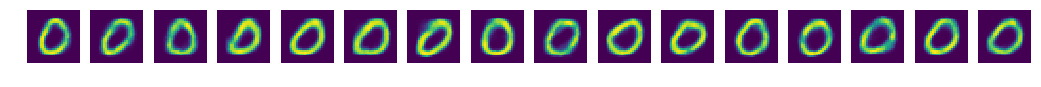

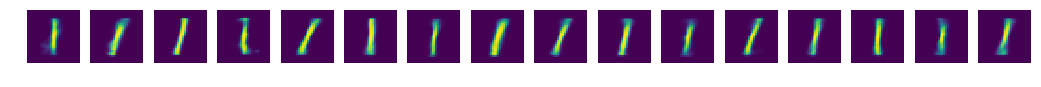

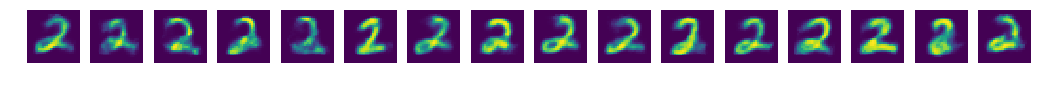

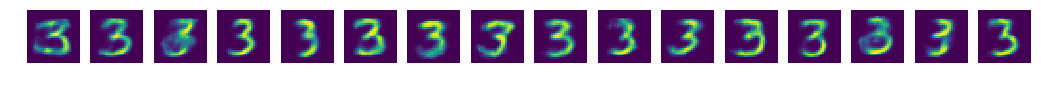

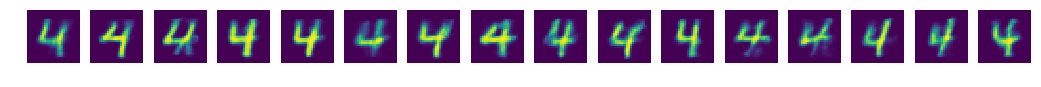

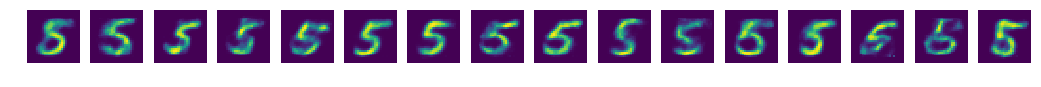

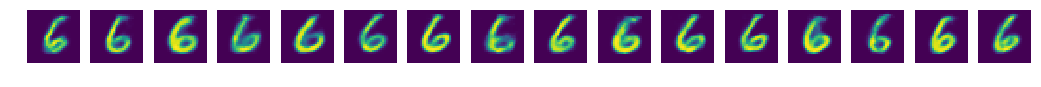

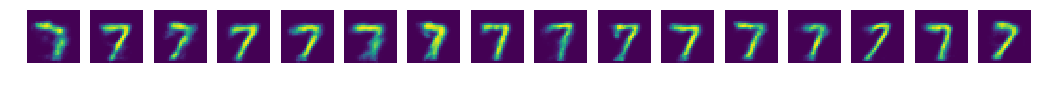

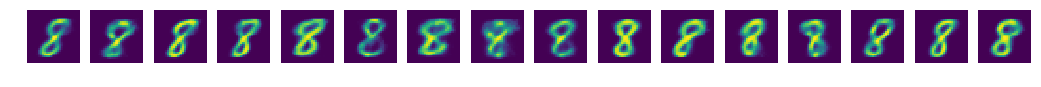

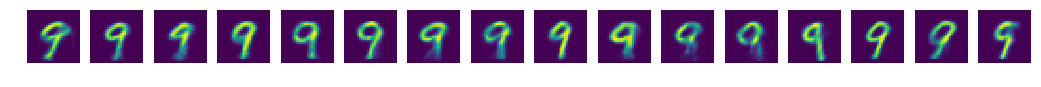

In [8]:
from utils import onehot
model.eval()

for digit in range(10):
    z = torch.randn(16, 32).to(DEVICE)
    y = onehot(10)(digit).repeat(16, 1).to(DEVICE)
    x_mu = model.sample(z, y)
    samples = x_mu.data.view(-1, 28, 28).cpu().numpy()

    f, axarr = plt.subplots(1, 16, figsize=(18, 12))
    for i, ax in enumerate(axarr.flat):
        ax.imshow(samples[i])
        ax.axis("off")

## Additional tips

You can change the built-in classifier with your own, for example if you want a CNN as a classifier you can do the following.

In [45]:
import torch.nn as nn
import torch.nn.functional as F

class ConvolutionalClassifier(nn.Module):
    def __init__(self):
        super(ConvolutionalClassifier, self).__init__()        
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=4)

        size = int((28 - 3) + 1)//4
        size = int((size - 3) + 1)//4
                
        self.fc1 = nn.Linear(32*size**2, 50)
        self.fc2 = nn.Linear(50, 10)
        
    def forward(self, x):
        batch, *_ = x.size()
        x = x.view(-1, 1, 28, 28)
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(x.view(batch, -1))
        x = self.fc1(x)
        x = self.fc2(x)
        return F.softmax(x, dim=-1)

classifier = ConvolutionalClassifier()
model.classifier = classifier

In [47]:
model

DeepGenerativeModel(
  (encoder): Encoder(
    (hidden): ModuleList(
      (0): Linear(in_features=794, out_features=256)
      (1): Linear(in_features=256, out_features=128)
    )
    (sample): GaussianSample(
      (mu): Linear(in_features=128, out_features=32)
      (log_var): Linear(in_features=128, out_features=32)
    )
  )
  (decoder): Decoder(
    (hidden): ModuleList(
      (0): Linear(in_features=42, out_features=128)
      (1): Linear(in_features=128, out_features=256)
    )
    (reconstruction): Linear(in_features=256, out_features=784)
    (output_activation): Sigmoid()
  )
  (classifier): ConvolutionalClassifier(
    (conv1): Conv2d (1, 64, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d (64, 32, kernel_size=(3, 3), stride=(1, 1))
    (pool): MaxPool2d(kernel_size=(4, 4), stride=(4, 4), dilation=(1, 1))
    (fc1): Linear(in_features=32, out_features=50)
    (fc2): Linear(in_features=50, out_features=10)
  )
)